In [1]:
import copy
from core.datasets import FER13
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
%matplotlib inline

In [2]:
class_names = [
    "Angry",
    "Disgust",
    "Fear",
    "Happy",
    "Sad",
    "Surprise",
    "Neutral",
]

In [3]:
preprocess = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [4]:
datasets = {
    x: FER13(
        root = "./data",
        train = True if x == "train" else False,
        transform = preprocess,
    )
    for x in ["train", "val"]
}

In [5]:
datasets["train"]

Dataset FER13
    Number of datapoints: 28709
    Root location: ./data
    Split: Train
    Compose(
    RandomCrop(size=(44, 44), padding=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [6]:
datasets["val"]

Dataset FER13
    Number of datapoints: 3589
    Root location: ./data
    Split: Test
    Compose(
    RandomCrop(size=(44, 44), padding=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [7]:
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=128,
        shuffle=False,
        num_workers=4
    )
    for x in ["train", "val"]
}
class_names = datasets["train"].classes
dataset_sizes = {
    x: len(datasets[x])
    for x in ["train", "val"]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

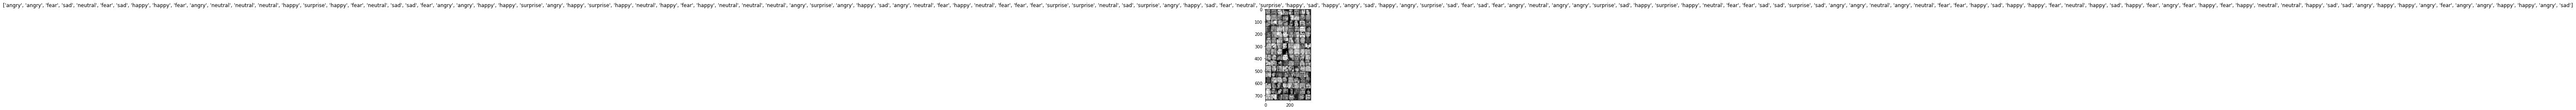

In [9]:
inputs, classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(
    model_conv,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=25
)

Epoch 0/24
----------
train Loss: 1.8090 Acc: 0.2813
val Loss: 1.7300 Acc: 0.3190

Epoch 1/24
----------
train Loss: 1.6881 Acc: 0.3398
val Loss: 1.6956 Acc: 0.3266

Epoch 2/24
----------
train Loss: 1.6702 Acc: 0.3438
val Loss: 1.6837 Acc: 0.3483

Epoch 3/24
----------
train Loss: 1.6570 Acc: 0.3514
val Loss: 1.6814 Acc: 0.3558

Epoch 4/24
----------
train Loss: 1.6504 Acc: 0.3536
val Loss: 1.6854 Acc: 0.3449

Epoch 5/24
----------
train Loss: 1.6445 Acc: 0.3570
val Loss: 1.6718 Acc: 0.3592

Epoch 6/24
----------
train Loss: 1.6493 Acc: 0.3567
val Loss: 1.6814 Acc: 0.3466

Epoch 7/24
----------
train Loss: 1.6311 Acc: 0.3609
val Loss: 1.6539 Acc: 0.3572

Epoch 8/24
----------
train Loss: 1.6323 Acc: 0.3616
val Loss: 1.6548 Acc: 0.3555

Epoch 9/24
----------
train Loss: 1.6271 Acc: 0.3661
val Loss: 1.6495 Acc: 0.3583

Epoch 10/24
----------
train Loss: 1.6270 Acc: 0.3640
val Loss: 1.6576 Acc: 0.3650

Epoch 11/24
----------
train Loss: 1.6267 Acc: 0.3650
val Loss: 1.6504 Acc: 0.3589

Ep

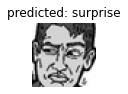

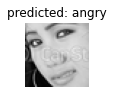

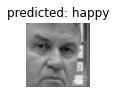

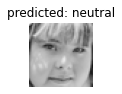

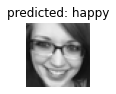

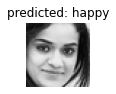

In [14]:
visualize_model(model_conv)